In [1]:
#mounting drive, uploading data files and importing all necessary packages
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip '/content/drive/MyDrive/GAN_Images_128.zip'

In [3]:
! unzip '/content/drive/MyDrive/HAM10000_GAN_data_128.zip'

Archive:  /content/drive/MyDrive/HAM10000_GAN_data_128.zip
  inflating: HAM10000_GAN_data_128.csv  


In [4]:
! unzip '/content/drive/MyDrive/HAM10000_metadata_gc.zip'

Archive:  /content/drive/MyDrive/HAM10000_metadata_gc.zip
  inflating: HAM10000_metadata       


In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_images_part_1_gc'

In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_images_part_2_gc'

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import seaborn as sns
from PIL import Image
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import keras
from keras.utils.np_utils import to_categorical 
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, GlobalAveragePooling2D, ZeroPadding2D
from keras.applications import vgg16
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.models import Model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  


In [8]:
#examining and lolading datasets

In [9]:
md = pd.read_csv("/content/HAM10000_metadata")
md

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [10]:
gans = pd.read_csv("/content/HAM10000_GAN_data_128.csv")
gans

,Unnamed: 0,image_id,dx
0,0,GAN_0000000.png,0
1,1,GAN_0000001.png,0
2,2,GAN_0000002.png,0
3,3,GAN_0000003.png,0
4,4,GAN_0000004.png,0
...,...,...,...
6001,6001,GAN_0006001.png,6
6002,6002,GAN_0006002.png,6
6003,6003,GAN_0006003.png,6
6004,6004,GAN_0006004.png,6


In [11]:
#resize image
im_size = 224

In [12]:
#create numerical labels that correspond to all disease categories to both datasets
lab_enc = LabelEncoder()
lab_enc.fit(md['dx'])
LabelEncoder()
print(list(lab_enc.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [13]:
md['label'] = lab_enc.transform(md["dx"]) 

In [14]:
def gan_dx(row):
  if row['dx'] == 0:
    return 'bkl'
  elif row['dx'] == 1:
    return 'nv'
  elif row['dx'] == 2:
    return 'df'
  elif row['dx'] == 3:
    return 'mel'
  elif row['dx'] == 4:
    return 'vasc'
  elif row['dx'] == 5:
    return 'bcc'
  elif row['dx'] == 6:
    return 'akiec'
  else:
    return None

gans['dx_s'] = gans.apply(lambda row: gan_dx(row), axis=1)
gans

,Unnamed: 0,image_id,dx,dx_s
0,0,GAN_0000000.png,0,bkl
1,1,GAN_0000001.png,0,bkl
2,2,GAN_0000002.png,0,bkl
3,3,GAN_0000003.png,0,bkl
4,4,GAN_0000004.png,0,bkl
...,...,...,...,...
6001,6001,GAN_0006001.png,6,akiec
6002,6002,GAN_0006002.png,6,akiec
6003,6003,GAN_0006003.png,6,akiec
6004,6004,GAN_0006004.png,6,akiec


In [15]:
def gan_label(row):
  if row['dx_s'] == 'akiec':
    return 0
  elif row['dx_s'] == 'bcc':
    return 1
  elif row['dx_s'] == 'bkl':
    return 2
  elif row['dx_s'] == 'df':
    return 3
  elif row['dx_s'] == 'mel':
    return 4
  elif row['dx_s'] == 'nv':
    return 5
  elif row['dx_s'] == 'vasc':
    return 6
  else:
    return None

gans['label'] = gans.apply(lambda row: gan_label(row), axis=1)
gans

,Unnamed: 0,image_id,dx,dx_s,label
0,0,GAN_0000000.png,0,bkl,2
1,1,GAN_0000001.png,0,bkl,2
2,2,GAN_0000002.png,0,bkl,2
3,3,GAN_0000003.png,0,bkl,2
4,4,GAN_0000004.png,0,bkl,2
...,...,...,...,...,...
6001,6001,GAN_0006001.png,6,akiec,0
6002,6002,GAN_0006002.png,6,akiec,0
6003,6003,GAN_0006003.png,6,akiec,0
6004,6004,GAN_0006004.png,6,akiec,0


In [16]:
#Add image paths and image ndarrays to all datasets

In [17]:
fldr1 = '/content/HAM10000_images_part_1'
fldr2 = '/content/HAM10000_images_part_2'

im_paths = []

for i in md['image_id']:
  fid = i

  fn = '/' + fid + '.jpg'

  if os.path.isfile(fldr1 + fn) == True:
    im_paths.append(fldr1+fn)
  else:
    im_paths.append(fldr2+fn)   

In [18]:
md['image_paths'] = im_paths
md

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label,image_paths
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2,/content/HAM10000_images_part_2/ISIC_0031633.jpg
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033084.jpg
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033550.jpg
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033536.jpg
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0032854.jpg


In [19]:
fldr_gan = '/content/GAN_Images_128'

im_path_gan = []

for i in gans['image_id']:
  fid_gan = i

  fn_gan = '/' + fid_gan 
  if os.path.isfile(fldr_gan+fn_gan) == True:
    im_path_gan.append(fldr_gan+fn_gan)
  else:
    im_path_gan.append('other')

In [20]:
gans['image_paths'] = im_path_gan
gans

,Unnamed: 0,image_id,dx,dx_s,label,image_paths
0,0,GAN_0000000.png,0,bkl,2,/content/GAN_Images_128/GAN_0000000.png
1,1,GAN_0000001.png,0,bkl,2,/content/GAN_Images_128/GAN_0000001.png
2,2,GAN_0000002.png,0,bkl,2,/content/GAN_Images_128/GAN_0000002.png
3,3,GAN_0000003.png,0,bkl,2,/content/GAN_Images_128/GAN_0000003.png
4,4,GAN_0000004.png,0,bkl,2,/content/GAN_Images_128/GAN_0000004.png
...,...,...,...,...,...,...
6001,6001,GAN_0006001.png,6,akiec,0,/content/GAN_Images_128/GAN_0006001.png
6002,6002,GAN_0006002.png,6,akiec,0,/content/GAN_Images_128/GAN_0006002.png
6003,6003,GAN_0006003.png,6,akiec,0,/content/GAN_Images_128/GAN_0006003.png
6004,6004,GAN_0006004.png,6,akiec,0,/content/GAN_Images_128/GAN_0006004.png


In [21]:
md['image'] = md['image_paths'].map(lambda x: np.asarray(Image.open(x).resize((im_size,im_size))))
md

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label,image_paths,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0027419.jpg,"[[[187, 150, 192], [190, 154, 195], [192, 156,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025030.jpg,"[[[24, 13, 22], [25, 13, 23], [24, 14, 23], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0026769.jpg,"[[[186, 127, 135], [188, 129, 137], [191, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025661.jpg,"[[[23, 11, 15], [24, 11, 18], [24, 10, 19], [2..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2,/content/HAM10000_images_part_2/ISIC_0031633.jpg,"[[[125, 83, 105], [132, 89, 112], [138, 93, 11..."
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033084.jpg,"[[[115, 92, 101], [108, 92, 96], [108, 91, 98]..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033550.jpg,"[[[4, 6, 3], [5, 6, 3], [6, 6, 5], [7, 8, 4], ..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033536.jpg,"[[[105, 92, 96], [109, 102, 103], [118, 109, 1..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0032854.jpg,"[[[156, 115, 138], [158, 117, 138], [160, 121,..."


In [22]:
gans['image'] = gans['image_paths'].map(lambda x: np.asarray(Image.open(x).resize((im_size,im_size))))
gans

,Unnamed: 0,image_id,dx,dx_s,label,image_paths,image
0,0,GAN_0000000.png,0,bkl,2,/content/GAN_Images_128/GAN_0000000.png,"[[[126, 87, 97], [134, 91, 106], [146, 97, 120..."
1,1,GAN_0000001.png,0,bkl,2,/content/GAN_Images_128/GAN_0000001.png,"[[[106, 69, 78], [109, 67, 83], [113, 64, 90],..."
2,2,GAN_0000002.png,0,bkl,2,/content/GAN_Images_128/GAN_0000002.png,"[[[147, 101, 114], [159, 109, 129], [178, 122,..."
3,3,GAN_0000003.png,0,bkl,2,/content/GAN_Images_128/GAN_0000003.png,"[[[97, 71, 78], [93, 66, 77], [87, 57, 76], [8..."
4,4,GAN_0000004.png,0,bkl,2,/content/GAN_Images_128/GAN_0000004.png,"[[[131, 89, 99], [139, 94, 109], [153, 101, 12..."
...,...,...,...,...,...,...,...
6001,6001,GAN_0006001.png,6,akiec,0,/content/GAN_Images_128/GAN_0006001.png,"[[[157, 108, 120], [172, 121, 137], [197, 143,..."
6002,6002,GAN_0006002.png,6,akiec,0,/content/GAN_Images_128/GAN_0006002.png,"[[[158, 104, 117], [175, 117, 135], [202, 137,..."
6003,6003,GAN_0006003.png,6,akiec,0,/content/GAN_Images_128/GAN_0006003.png,"[[[161, 115, 126], [175, 124, 139], [196, 138,..."
6004,6004,GAN_0006004.png,6,akiec,0,/content/GAN_Images_128/GAN_0006004.png,"[[[139, 94, 104], [152, 101, 116], [172, 112, ..."


In [23]:
#divide data into test and train, standardize arrays and add gan images to training set, turn disease labels to arrays

In [24]:
train, test = train_test_split(md, test_size=0.25, random_state=29, shuffle=True)

In [25]:
trainX = np.array(train["image"].tolist())
trainX = trainX/225

ganX = np.array(gans["image"].tolist())
ganX = ganX/225

tr_in = np.concatenate((trainX, ganX), axis=0)
tr_in

array([[[[1.03555556, 0.89333333, 0.99555556],
         [1.02666667, 0.88888889, 1.02222222],
         [1.01777778, 0.88      , 1.01777778],
         ...,
         [0.93333333, 0.76888889, 0.84888889],
         [0.93333333, 0.78666667, 0.87555556],
         [0.93333333, 0.79555556, 0.88888889]],

        [[1.04      , 0.88444444, 1.        ],
         [1.02222222, 0.88888889, 1.00444444],
         [1.02666667, 0.89333333, 1.01333333],
         ...,
         [0.95555556, 0.79555556, 0.87111111],
         [0.94666667, 0.8       , 0.88444444],
         [0.94222222, 0.8       , 0.88888889]],

        [[1.03111111, 0.88      , 0.99555556],
         [1.02666667, 0.88444444, 1.01333333],
         [1.03111111, 0.89333333, 1.00888889],
         ...,
         [0.95111111, 0.79555556, 0.86666667],
         [0.94666667, 0.8       , 0.87555556],
         [0.95111111, 0.79111111, 0.88      ]],

        ...,

        [[1.03555556, 0.87555556, 0.99555556],
         [1.02666667, 0.87111111, 0.98222222]

In [26]:
trainY = train['label']
trainY_dx = to_categorical(trainY, num_classes=7)

ganY = gans['label']
ganY_dx = to_categorical(ganY, num_classes=7)

tr_out = np.concatenate((trainY_dx, ganY_dx), axis=0)
tr_out

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [27]:
testX = np.array(test["image"].tolist())
testX = testX/225

testY = test['label']
testY_dx = to_categorical(testY, num_classes=7)

In [28]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [29]:
#create a simple CNN model with 3 convolutional layers with pooling layers and dropout layers, then two dense layers ending in softmax activation

In [30]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(im_size, im_size, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 256)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 256)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 128)       0

In [31]:
#hyperparameters and model fitting
batch_size = 16 
epochs = 75

In [32]:
mod_fit = model.fit(
    tr_in, tr_out,
    epochs=epochs,
    batch_size = batch_size,
    verbose=2)

Epoch 1/75
845/845 - 33s - loss: 1.0683 - acc: 0.6571 - 33s/epoch - 39ms/step
Epoch 2/75
845/845 - 21s - loss: 0.6387 - acc: 0.7975 - 21s/epoch - 24ms/step
Epoch 3/75
845/845 - 21s - loss: 0.5466 - acc: 0.8193 - 21s/epoch - 24ms/step
Epoch 4/75
845/845 - 21s - loss: 0.5034 - acc: 0.8261 - 21s/epoch - 24ms/step
Epoch 5/75
845/845 - 21s - loss: 0.4740 - acc: 0.8339 - 21s/epoch - 25ms/step
Epoch 6/75
845/845 - 21s - loss: 0.4495 - acc: 0.8423 - 21s/epoch - 24ms/step
Epoch 7/75
845/845 - 21s - loss: 0.4263 - acc: 0.8466 - 21s/epoch - 24ms/step
Epoch 8/75
845/845 - 21s - loss: 0.4047 - acc: 0.8560 - 21s/epoch - 24ms/step
Epoch 9/75
845/845 - 21s - loss: 0.3830 - acc: 0.8637 - 21s/epoch - 24ms/step
Epoch 10/75
845/845 - 21s - loss: 0.3695 - acc: 0.8676 - 21s/epoch - 24ms/step
Epoch 11/75
845/845 - 21s - loss: 0.3556 - acc: 0.8706 - 21s/epoch - 24ms/step
Epoch 12/75
845/845 - 20s - loss: 0.3422 - acc: 0.8759 - 20s/epoch - 24ms/step
Epoch 13/75
845/845 - 21s - loss: 0.3327 - acc: 0.8799 - 21s/

In [33]:
#overall model accuracy, class wise accuracies, and predictions

In [34]:
mod_acc = model.evaluate(testX, testY_dx)
print('Test Accuracy: ', mod_acc[1])

79/79 [==============================] - 2s 21ms/step - loss: 1.5602 - acc: 0.6949
Test Accuracy:  0.694888174533844


In [35]:
y_preds = model.predict(testX)

79/79 [==============================] - 2s 18ms/step


In [36]:
y_pred_classes = np.argmax(y_preds, axis=1)

In [37]:
y_true = np.argmax(testY_dx, axis=1)

In [38]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred_classes, target_names = ['Akiec', 'Bcc', 'Bkl', 'Df', 'Mel', 'Nv', 'Vasc'])
print(report)

              precision    recall  f1-score   support

       Akiec       0.62      0.09      0.15        91
         Bcc       0.38      0.19      0.25       132
         Bkl       0.32      0.28      0.30       271
          Df       0.25      0.03      0.06        30
         Mel       0.39      0.15      0.22       277
          Nv       0.77      0.94      0.85      1669
        Vasc       0.59      0.50      0.54        34

    accuracy                           0.69      2504
   macro avg       0.47      0.31      0.34      2504
weighted avg       0.64      0.69      0.65      2504



In [39]:
def classwise_accuracy():
   a = pd.crosstab(y_true,y_pred_classes)
   print(a.max(axis=1)/a.sum(axis=1))
classwise_accuracy()

row_0
0    0.373626
1    0.401515
2    0.623616
3    0.500000
4    0.707581
5    0.941282
6    0.500000
dtype: float64


In [40]:
#confusion matrices misclassification percentages 

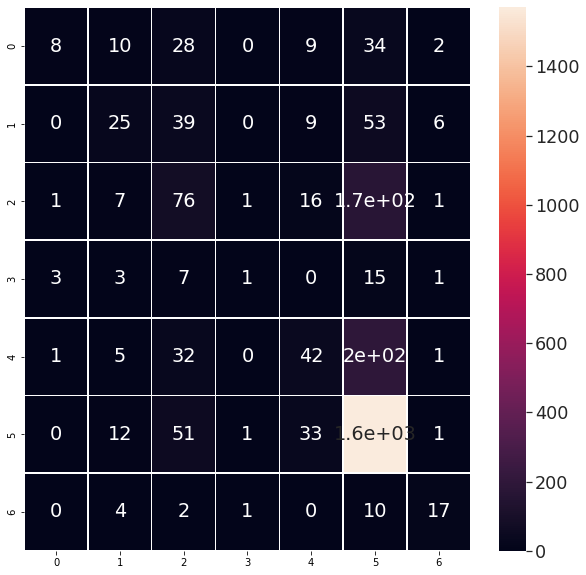

In [41]:
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [42]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)

incorr_fraction = incorr_fraction.tolist()

incorr_fraction = [round(item, 2) for item in incorr_fraction]

incorr_fraction

[0.91, 0.81, 0.72, 0.97, 0.85, 0.06, 0.5]

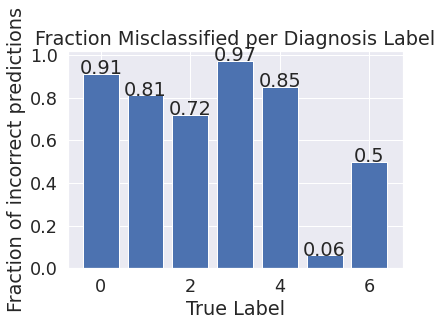

In [43]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
  
if __name__ == '__main__':
  plt.bar(np.arange(7), incorr_fraction)
  addlabels(np.arange(7), incorr_fraction)
  plt.title("Fraction Misclassified per Diagnosis Label")
  plt.xlabel('True Label')
  plt.ylabel('Fraction of incorrect predictions')